<a href="https://colab.research.google.com/github/jonbmartin/Gradient-Waveform-Errors-Demos/blob/main/Ex3_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jonbmartin/Gradient-Waveform-Errors-Demos

fatal: destination path 'Gradient-Waveform-Errors-Demos' already exists and is not an empty directory.


In [2]:
import sys
sys.path.insert(0,'/content/Gradient-Waveform-Errors-Demos')
sys.path.insert(0,'/content/Gradient-Waveform-Errors-Demos/utils/')

In [3]:
import random
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data

from belief_network_util import *
from custom_environments_belief import *


In [4]:
# make sure that all seeds are set for reproducibility
seed = 12
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [5]:
# import data
data = sio.loadmat('Gradient-Waveform-Errors-Demos/data/all_ideal_waveforms_normalized.mat')
g_ideal_m = np.squeeze(data['ideal'])

axis = 'ax'

belief_checkpoint_path = 'scanner_data_training_augmented_ampfeature_'+axis+'.pt'


torch.cuda.empty_cache()

In [6]:


#########################################
#####
# Training to initialize the belief network  #
##############################################

pretrain_belief_network = True
plotting_belief_results = True
return_traj_y = False
input_size = 3 # (2 states and 1 action) - just gideal amplitude, precomp amp, action
n_epochs = 5


GMAX_CONSTRAINT = 275 # mT/m
SMAX_CONSTRAINT = 100 # mT/m/s

# set up which device we will be using
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device to be used = {device}')

normalize = False
buffer_length = int(50_000)

# set up our TCN model! optimized hyperparameters:
channel_sizes = [48] * 5 # temporal causal layer channels
kernel_size = 16 # convolution kernel size
dropout = 0.002
batch_size = 32
lr = 8.4E-04
weight_decay = 8.7E-08
eps = 4.24E-06
beta1 = 0.9
beta2 = 0.999999
window_size = 75
predict_point = 65

model_params = {
    'input_size':   3,
    'output_size':  1,
    'num_channels': channel_sizes,
    'kernel_size':  kernel_size,
    'dropout':      dropout
}
belief_model = TCN(**model_params)
#belief_model.float() # TODO: this might cause things to go way more slowly (too precise)

obs_space = 5
act_space = 1
belief_training_buffer = BeliefWindowBuffer(obs_space, act_space,
                                    buffer_length=buffer_length)


Device to be used = cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


loading training/testing data from: Gradient-Waveform-Errors-Demos/data/scanner_data_gax_trainandtest_0424.csv


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


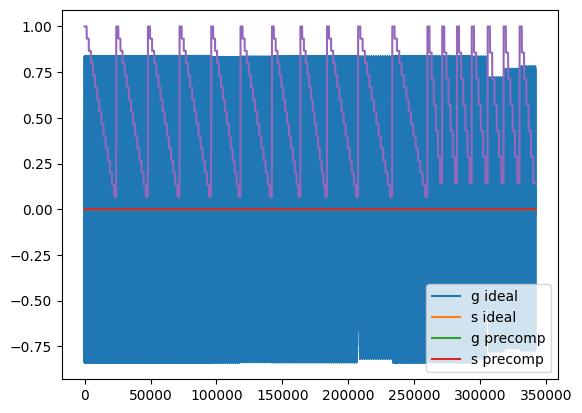

Status: Pretraining the belief model
Train size = 259754
range(0, 259679)
range(0, 81819)
size of x train data = torch.Size([259679, 3, 75])
size of y train data = torch.Size([259679, 1])
size of x test data = torch.Size([81819, 3, 75])
size of y test data = torch.Size([81819, 1])
Training and testing belief network
torch.Size([259679, 3, 75])


/content/Gradient-Waveform-Errors-Demos/utils/belief_network_util.py:229: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/content/Gradient-Waveform-Errors-Demos/utils/belief_network_util.py:250: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


New best test cost: 
Epoch 0: train cost 1.07E-02, test cost 6.43E-03
New best test cost: 
Epoch 1: train cost 6.50E-03, test cost 4.21E-03
Epoch 2: train cost 5.62E-03, test cost 4.36E-03
New best test cost: 
Epoch 3: train cost 5.31E-03, test cost 3.61E-03
New best test cost: 
Epoch 4: train cost 5.07E-03, test cost 3.51E-03


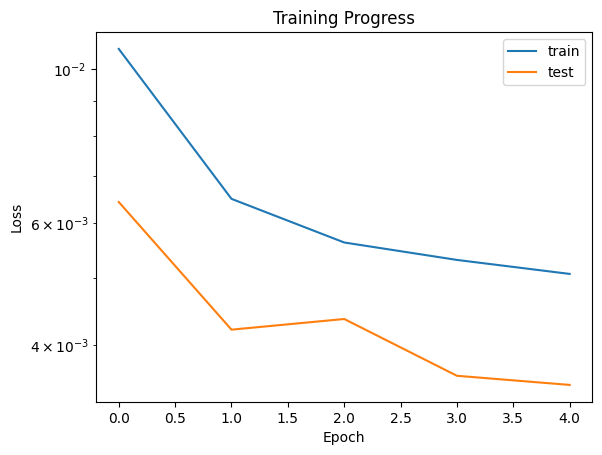

Status: Belief network pretraining complete, saving model at scanner_data_training_augmented_ampfeature_ax.pt


In [7]:

# Loading the NORMALIZED data with feature scale
if axis == 'ax':
    file = 'Gradient-Waveform-Errors-Demos/data/scanner_data_gax_trainandtest_0424.csv'
elif axis == 'sag':
    file = 'Gradient-Waveform-Errors-Demos/data/scanner_data_gsag_trainandtest_0424.csv'
elif axis == 'cor':
    file = 'Gradient-Waveform-Errors-Demos/data/scanner_data_gcor_trainandtest_0424.csv'

print('loading training/testing data from: '+ file)
belief_training_buffer.add_transitions_from_csv(file)
collected_observations = belief_training_buffer.get_observation_v_array()

feature_indices = [0, 4] # input grad amp and waveform scale
scale_factors = np.squeeze(collected_observations[:,4]) # normalized scale factors
max_scale_mt_m = 275 # [mT/m], the normalizing max amplitude

if plotting_belief_results:
    plt.plot(collected_observations)
    plt.legend(['g ideal', 's ideal', 'g precomp', 's precomp'])
    plt.show()

data_normalized_flag = True

if pretrain_belief_network:

    print("Status: Pretraining the belief model")
    train_test_split = 0.7603
    train_size = int(len(belief_training_buffer.observed_error_v) * train_test_split)
    print(f'Train size = {train_size}' )
    X_train, X_test, y_train, y_test = belief_training_buffer.return_X_Y_train_test(train_test_split=train_test_split,
                                             normalize=not data_normalized_flag, rl_env=None,
                                             feature_indices=feature_indices)

    X_train, y_train = create_dataset(X_train, y_train, window_size=window_size, predict_point=predict_point,
                                      predict_single_timepoint=True,
                                      pct_data_to_keep=1, return_traj_y=return_traj_y)
    X_test, y_test = create_dataset(X_test, y_test, window_size=window_size, predict_point=predict_point,
                                    predict_single_timepoint=True,
                                    pct_data_to_keep=1, return_traj_y=return_traj_y)

    X_train = X_train.transpose(1, 2)
    X_test = X_test.transpose(1, 2)

    # should be: [number of examples, data dimension, timeseries length (features)]
    print(f'size of x train data = {X_train.size()}')
    print(f'size of y train data = {y_train.size()}')
    print(f'size of x test data = {X_test.size()}')
    print(f'size of y test data = {y_test.size()}')

    optimizer = optim.Adam(belief_model.parameters(),betas=(beta1, beta2), eps=eps,
                           lr=lr, weight_decay=weight_decay)
    loss_fn = nn.L1Loss()

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

    belief_model, test_cost, best_params = train_and_test_belief_network(n_epochs, belief_model, loss_fn, optimizer, loader,
                                            X_train, X_test, y_train, y_test, device=device)

    print(f"Status: Belief network pretraining complete, saving model at {belief_checkpoint_path}")
    checkpoint = {
        'epoch': n_epochs,
        'state_dict': best_params,
        'optimizer': optimizer.state_dict()
    }
    save_checkpoint(checkpoint, belief_checkpoint_path)



In [1]:
if plotting_belief_results:
    print("Status: Plotting the initial results")
    train_test_split = 0.7603
    train_size = int(len(belief_training_buffer.observed_error_v) * train_test_split)
    print(f'Train size = {train_size}' )

    X_train, X_test, y_train, y_test = belief_training_buffer.return_X_Y_train_test(train_test_split=train_test_split, normalize=not data_normalized_flag,
        rl_env=None, feature_indices=feature_indices)


    X_train, y_train = create_dataset(X_train, y_train, window_size=window_size, predict_point=predict_point,
                                      predict_single_timepoint=True,
                                      pct_data_to_keep=1, return_traj_y=return_traj_y)
    X_test, y_test = create_dataset(X_test, y_test, window_size=window_size, predict_point=predict_point,
                                    predict_single_timepoint=True,
                                    pct_data_to_keep=1, return_traj_y=return_traj_y)
    # plt.plot(X_train[:,0])
    # plt.plot(y_train)
    # plt.title('X_train and y_train')
    # plt.show()
    # plt.plot(X_test[:,0])
    # plt.plot(y_test)
    # plt.title('X_test and y_test')
    # plt.show()
    print(f'ytrain_mean = {torch.mean(y_train)}')
    X_train = X_train.transpose(1, 2)
    X_test = X_test.transpose(1, 2)
    X_test = X_test.to(device)
    belief_model.eval()
    with torch.no_grad():
        observed_error_v = np.expand_dims(np.array(belief_training_buffer.observed_error_v),1)

        # train_plot = np.ones_like(observed_error_v) * 0
        # train_plot[window_size:train_size] = belief_model(X_train)
        # train_plot = np.squeeze(np.roll(train_plot,-predict_point))

        # shift test predictions for plotting
        test_plot = np.ones_like(observed_error_v) * 0
        output = belief_model(X_test)
        test_plot[train_size+window_size:len(observed_error_v)] = output.cpu().numpy()
        # test_plot = np.squeeze(np.roll(test_plot,-predict_point))

    plt.plot(np.squeeze(observed_error_v)*scale_factors*max_scale_mt_m) # this is the ground-truth error that we are trying to predict
    #plt.plot(train_plot*scale_factors*max_scale_mt_m, c='r')
    plt.plot(test_plot*scale_factors*max_scale_mt_m, c='g')
    plt.plot(scale_factors*max_scale_mt_m)
    plt.xlim(305_000,310_000)
    plt.title('normalized output')
    plt.legend(['true waveform', 'train waveform prediction','test waveform prediction', 'scalefeature'])
    plt.show()

    plt.plot(np.abs(test_plot- np.squeeze(observed_error_v))*scale_factors*max_scale_mt_m, c='r')
    plt.xlim(305_000,310_000)
    plt.title('error (mT/m)')
    plt.show()

NameError: name 'plotting_belief_results' is not defined